# Desafio de Previsão Industrial - Pipeline Ponta a Ponta

Este notebook implementa um pipeline completo de Machine Learning para previsão de consumo de energia.

## 1. Configuração e Importações


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')


## 2. Carregamento dos Dados
Carregando os dados sintéticos dos sensores.


In [2]:
df = pd.read_csv("../data/sensor_data.csv", parse_dates=['timestamp'])
df.set_index('timestamp', inplace=True)
print(df.head())
print(df.info())


                     potencia_watts
timestamp                          
2025-01-01 00:00:00      106.107314
2025-01-01 00:00:30      102.092134
2025-01-01 00:01:00      107.910955
2025-01-01 00:01:30      101.657196
2025-01-01 00:02:00      104.560743
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 86401 entries, 2025-01-01 00:00:00 to 2025-01-31 00:00:00
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   potencia_watts  85713 non-null  float64
dtypes: float64(1)
memory usage: 1.3 MB
None


## 3. Pré-processamento
- Reamostragem para 15 minutos.
- Preenchimento de lacunas (gaps) usando interpolação linear.


In [3]:
# Reamostragem para 15min
df_resampled = df.resample('15min').mean()

# Preenchimento de Gaps (Interpolação)
df_resampled['potencia_watts'] = df_resampled['potencia_watts'].interpolate(method='linear')

print(f"Novo formato após reamostragem: {df_resampled.shape}")


Novo formato após reamostragem: (2881, 1)


## 4. Análise Exploratória de Dados (EDA)
Visualizando a série temporal, verificando estacionariedade e decompondo componentes.


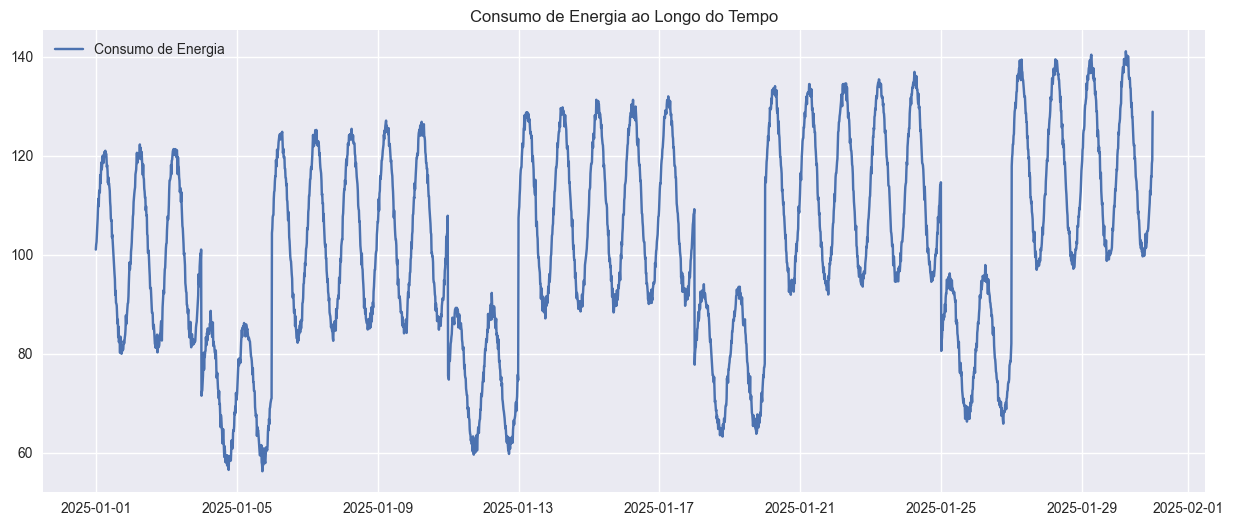

Estatística ADF: -8.562500335565408
p-valor: 8.619537433688311e-14
A série é estacionária.


In [4]:
# Gráfico da Série Temporal
plt.figure(figsize=(15, 6))
plt.plot(df_resampled.index, df_resampled['potencia_watts'], label='Consumo de Energia')
plt.title('Consumo de Energia ao Longo do Tempo')
plt.legend()
plt.show()

# Teste de Estacionariedade (ADF)
result = adfuller(df_resampled['potencia_watts'].dropna())
print(f'Estatística ADF: {result[0]}')
print(f'p-valor: {result[1]}')
if result[1] < 0.05:
    print("A série é estacionária.")
else:
    print("A série NÃO é estacionária.")


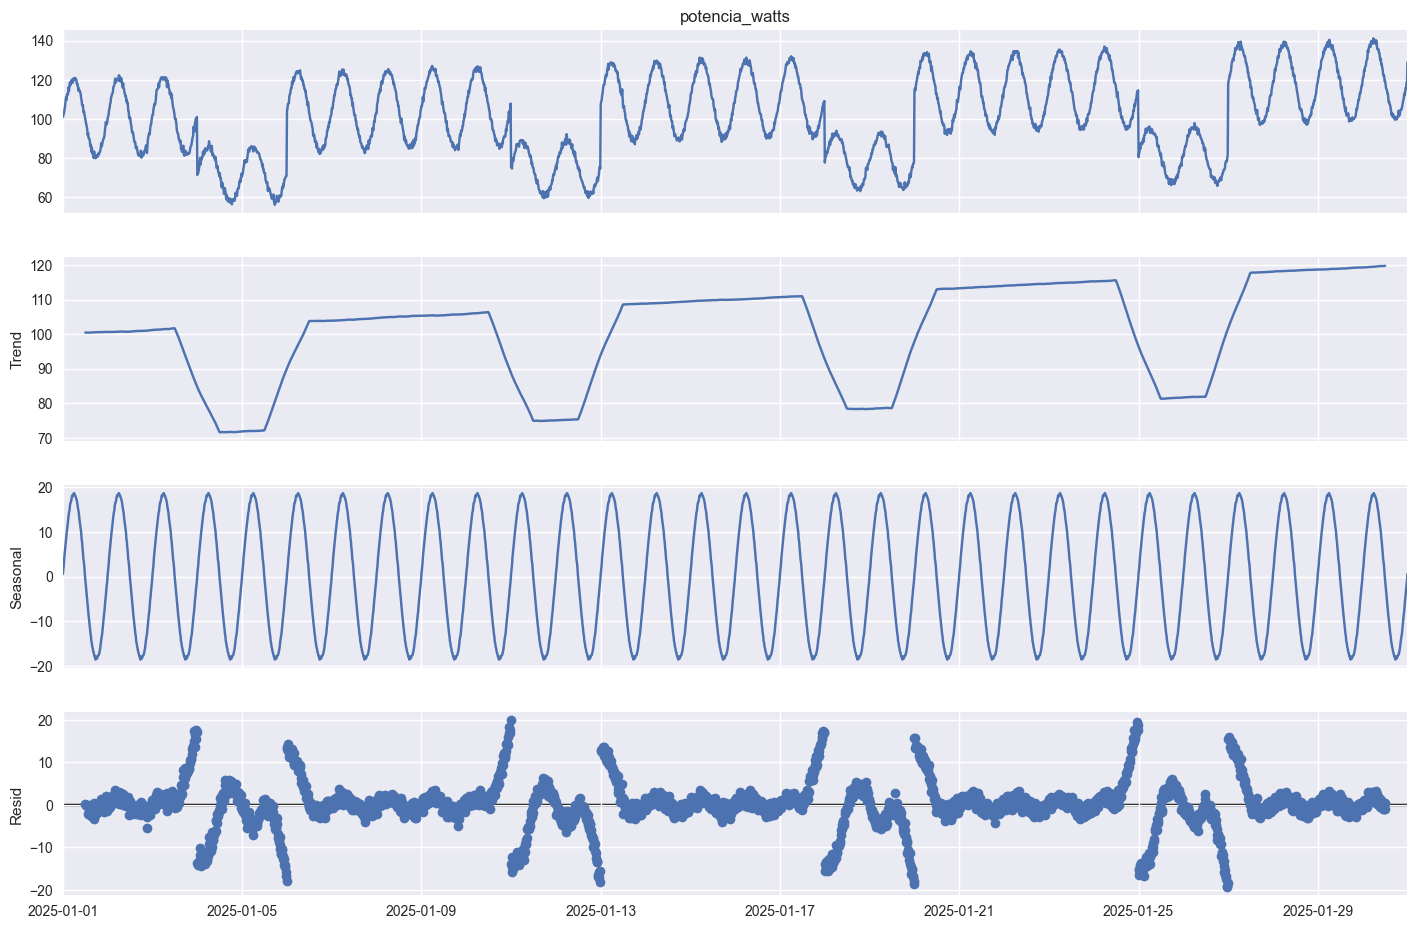

In [5]:
# Decomposição
decomposition = seasonal_decompose(df_resampled['potencia_watts'].dropna(), period=96) # 96 * 15min = 24h
fig = decomposition.plot()
fig.set_size_inches(15, 10)
plt.show()


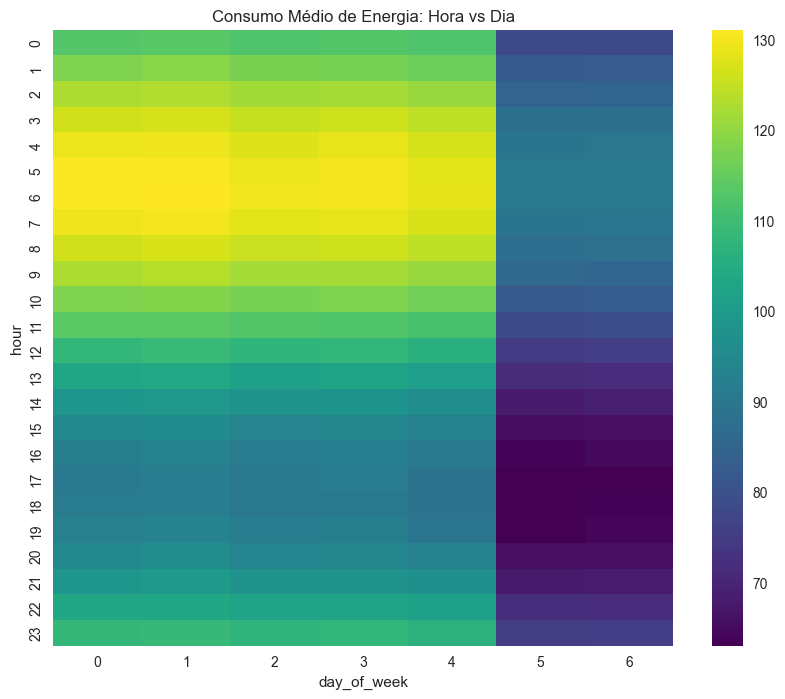

In [6]:
# Mapa de Calor (Dia vs Hora)
df_resampled['hour'] = df_resampled.index.hour
df_resampled['day_of_week'] = df_resampled.index.dayofweek
pivot_table = df_resampled.pivot_table(index='hour', columns='day_of_week', values='potencia_watts', aggfunc='mean')

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, cmap='viridis', annot=False)
plt.title('Consumo Médio de Energia: Hora vs Dia')
plt.show()


## 5. Engenharia de Atributos (Feature Engineering)
Criando atributos cíclicos para tempo, defasagens (lags) e estatísticas móveis.


In [7]:
# Atributos Cíclicos
df_resampled['hour_sin'] = np.sin(2 * np.pi * df_resampled['hour'] / 24)
df_resampled['hour_cos'] = np.cos(2 * np.pi * df_resampled['hour'] / 24)
df_resampled['day_sin'] = np.sin(2 * np.pi * df_resampled['day_of_week'] / 7)
df_resampled['day_cos'] = np.cos(2 * np.pi * df_resampled['day_of_week'] / 7)

# Lags (Defasagens)
df_resampled['lag_1'] = df_resampled['potencia_watts'].shift(1)
df_resampled['lag_2'] = df_resampled['potencia_watts'].shift(2)
df_resampled['lag_24h'] = df_resampled['potencia_watts'].shift(96) # 24h * 4 (chunks de 15min)

# Estatísticas Móveis (Rolling stats)
df_resampled['rolling_mean'] = df_resampled['potencia_watts'].rolling(window=4).mean()
df_resampled['rolling_std'] = df_resampled['potencia_watts'].rolling(window=4).std()

df_model = df_resampled.dropna()
print(df_model.head())


                     potencia_watts  hour  day_of_week  hour_sin  hour_cos  \
timestamp                                                                    
2025-01-02 00:00:00      100.622327     0            3  0.000000  1.000000   
2025-01-02 00:15:00      101.375375     0            3  0.000000  1.000000   
2025-01-02 00:30:00      102.493721     0            3  0.000000  1.000000   
2025-01-02 00:45:00      104.702663     0            3  0.000000  1.000000   
2025-01-02 01:00:00      105.397979     1            3  0.258819  0.965926   

                      day_sin   day_cos       lag_1       lag_2     lag_24h  \
timestamp                                                                     
2025-01-02 00:00:00  0.433884 -0.900969   98.188476   98.446489  101.024639   
2025-01-02 00:15:00  0.433884 -0.900969  100.622327   98.188476  102.036383   
2025-01-02 00:30:00  0.433884 -0.900969  101.375375  100.622327  102.574101   
2025-01-02 00:45:00  0.433884 -0.900969  102.493721  101.3

## 6. Modelagem
Comparando AutoARIMA (Estatístico) e XGBoost (Machine Learning).


In [8]:
# Divisão Treino/Teste
train_size = int(len(df_model) * 0.8)
train, test = df_model.iloc[:train_size], df_model.iloc[train_size:]
print(f"Tamanho Treino: {len(train)}, Tamanho Teste: {len(test)}")


Tamanho Treino: 2228, Tamanho Teste: 557


Treinando AutoARIMA...
ARIMA RMSE: 32.543525034864594


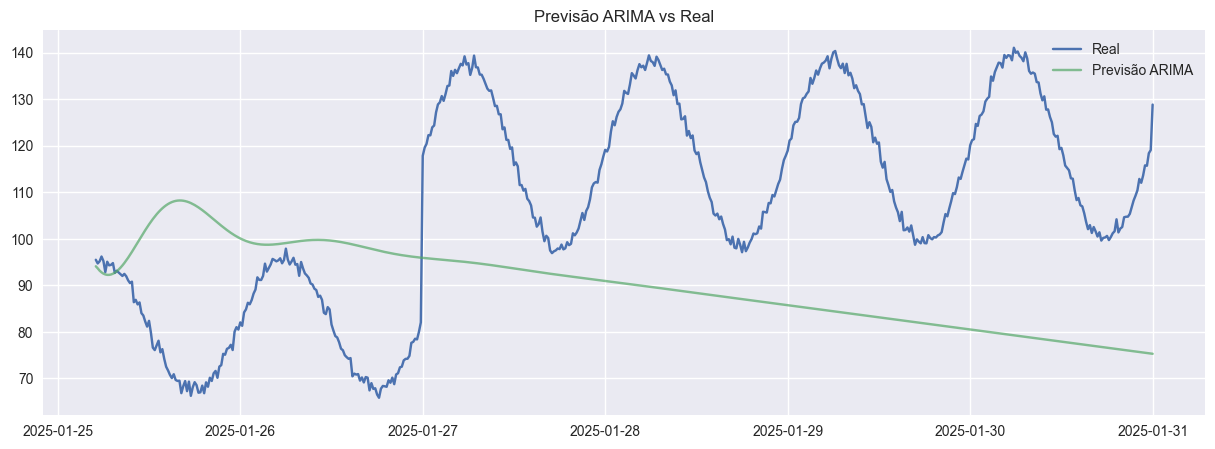

In [9]:
# Modelo 1: AutoARIMA
# Nota: ARIMA Sazonal pode ser lento. Usando parâmetros simplificados para demonstração.
print("Treinando AutoARIMA...")
model_arima = pm.auto_arima(train['potencia_watts'], seasonal=False, 
                            max_p=3, max_q=3, 
                            step_wise=True, suppress_warnings=True, error_action='ignore')

preds_arima = model_arima.predict(n_periods=len(test))
rmse_arima = np.sqrt(mean_squared_error(test['potencia_watts'], preds_arima))
print(f"ARIMA RMSE: {rmse_arima}")

# Plotar resultados ARIMA
plt.figure(figsize=(15, 5))
plt.plot(test.index, test['potencia_watts'], label='Real')
plt.plot(test.index, preds_arima, label='Previsão ARIMA', alpha=0.7)
plt.legend()
plt.title('Previsão ARIMA vs Real')
plt.show()


Treinando XGBoost...
XGBoost RMSE: 1.9337547007008085


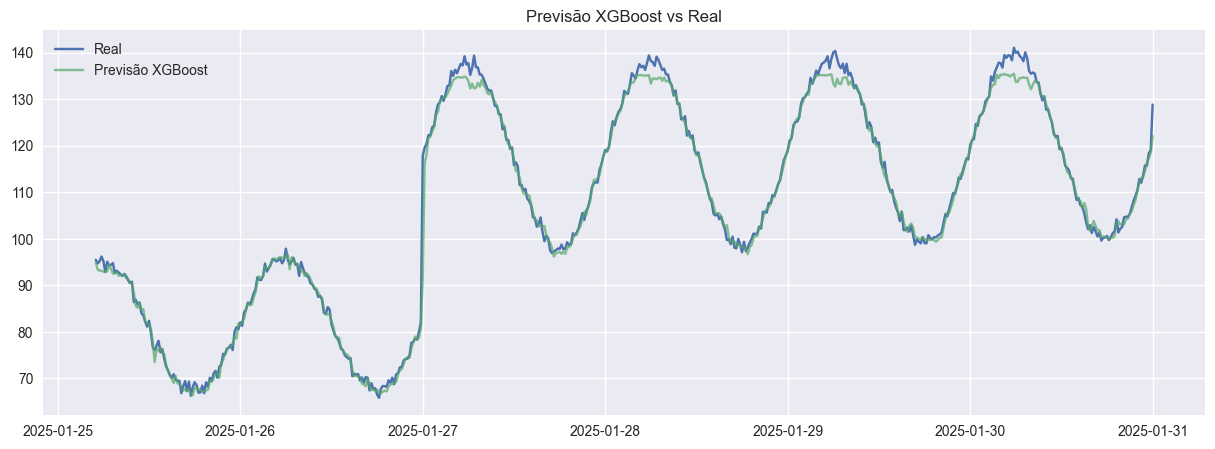

In [10]:
# Modelo 2: XGBoost
print("Treinando XGBoost...")
features = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'lag_1', 'lag_2', 'lag_24h', 'rolling_mean', 'rolling_std']
X_train, y_train = train[features], train['potencia_watts']
X_test, y_test = test[features], test['potencia_watts']

model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1)
model_xgb.fit(X_train, y_train)
preds_xgb = model_xgb.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, preds_xgb))
print(f"XGBoost RMSE: {rmse_xgb}")

# Plotar resultados XGBoost
plt.figure(figsize=(15, 5))
plt.plot(test.index, y_test, label='Real')
plt.plot(test.index, preds_xgb, label='Previsão XGBoost', alpha=0.7)
plt.legend()
plt.title('Previsão XGBoost vs Real')
plt.show()


## 7. Conclusão
Comparação de desempenho dos modelos.


In [11]:
results = pd.DataFrame({
    'Modelo': ['AutoARIMA', 'XGBoost'],
    'RMSE': [rmse_arima, rmse_xgb]
})
print(results)

best_model = results.loc[results['RMSE'].idxmin()]
print(f"\nO melhor modelo é {best_model['Modelo']} com RMSE {best_model['RMSE']:.4f}")


      Modelo       RMSE
0  AutoARIMA  32.543525
1    XGBoost   1.933755

O melhor modelo é XGBoost com RMSE 1.9338
